<a href="https://colab.research.google.com/github/LinaElk86/AI-RiskInvest/blob/main/Ai-RiskInvest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
# ============================================================
# AI-RiskInvest
# Prédiction boursière et aide à la gestion du risque
# Dataset : aapl_split_adjusted.csv
# Environnement : Google Colab + GitHub
# ============================================================


# ===================== 1. IMPORTATION DES LIBRAIRIES =====================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib   # pour sauvegarder le modèle

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error



In [64]:



# ===================== 2. CHARGEMENT DES DONNÉES =====================

df = pd.read_csv("aapl_split_adjusted.csv")

print("Aperçu des données :")
print(df.head())




Aperçu des données :
         date    open    high     low   close     volume  raw_close  \
0  1980-12-12  0.1283  0.1289  0.1283  0.1283  469033600    28.7392   
1  1980-12-15  0.1222  0.1222  0.1217  0.1217  175884800    27.2608   
2  1980-12-16  0.1133  0.1133  0.1127  0.1127  105728000    25.2448   
3  1980-12-17  0.1155  0.1161  0.1155  0.1155   86441600    25.8720   
4  1980-12-18  0.1189  0.1194  0.1189  0.1189   73449600    26.6336   

   change_percent  avg_vol_20d  
0             NaN          NaN  
1           -5.14          NaN  
2           -7.44          NaN  
3            2.53          NaN  
4            2.91          NaN  


In [65]:


# ===================== 3. ANALYSE EXPLORATOIRE =====================

print("\nInformations générales :")
print(df.info())

print("\nStatistiques descriptives :")
print(df.describe())





Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10925 entries, 0 to 10924
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            10925 non-null  object 
 1   open            10925 non-null  float64
 2   high            10925 non-null  float64
 3   low             10925 non-null  float64
 4   close           10925 non-null  float64
 5   volume          10925 non-null  int64  
 6   raw_close       10925 non-null  float64
 7   change_percent  10924 non-null  float64
 8   avg_vol_20d     10906 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 768.3+ KB
None

Statistiques descriptives :
               open          high           low         close        volume  \
count  10925.000000  10925.000000  10925.000000  10925.000000  1.092500e+04   
mean      21.112307     21.340212     20.892900     21.126325  3.197690e+08   
std       43.765008     44.236044   

In [67]:


# ===================== 4. PRÉTRAITEMENT =====================

# Suppression des valeurs manquantes
df = df.dropna()

# Conversion de la date
df['date'] = pd.to_datetime(df['date'])

# Tri chronologique
df = df.sort_values('date')

# Variable cible
data = df[['close']]


In [68]:



# ===================== 5. NORMALISATION =====================

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)




In [69]:


# ===================== 6. CRÉATION DES SÉQUENCES TEMPORELLES =====================

def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)

print("Dimensions X :", X.shape)
print("Dimensions y :", y.shape)



Dimensions X : (10846, 60, 1)
Dimensions y : (10846, 1)


In [70]:




# ===================== 7. SPLIT TRAIN / TEST =====================

split_index = int(0.8 * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]



In [71]:

# ===================== 8. ENTRAÎNEMENT DU MODÈLE =====================

# Mise en forme pour la régression linéaire
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

model = LinearRegression()
model.fit(X_train_flat, y_train)


LinearRegression()

In [73]:


# ===================== 9. PRÉDICTION =====================

predictions = model.predict(X_test_flat)


In [74]:


# ===================== 10. ÉVALUATION =====================

rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)

print("\nÉvaluation du modèle :")
print("RMSE :", rmse)
print("MAE :", mae)



Évaluation du modèle :
RMSE : 0.009966186108438514
MAE : 0.006253710296396488


In [75]:


# ===================== 11. CALCUL DU RISK SCORE =====================

def calculate_risk(rmse):
    """
    Classification simple du risque basé sur l'erreur du modèle
    """
    if rmse < 0.02:
        return "Faible risque"
    elif rmse < 0.05:
        return "Risque moyen"
    else:
        return "Risque élevé"

risk_level = calculate_risk(rmse)

print("Niveau de risque :", risk_level)



Niveau de risque : Faible risque


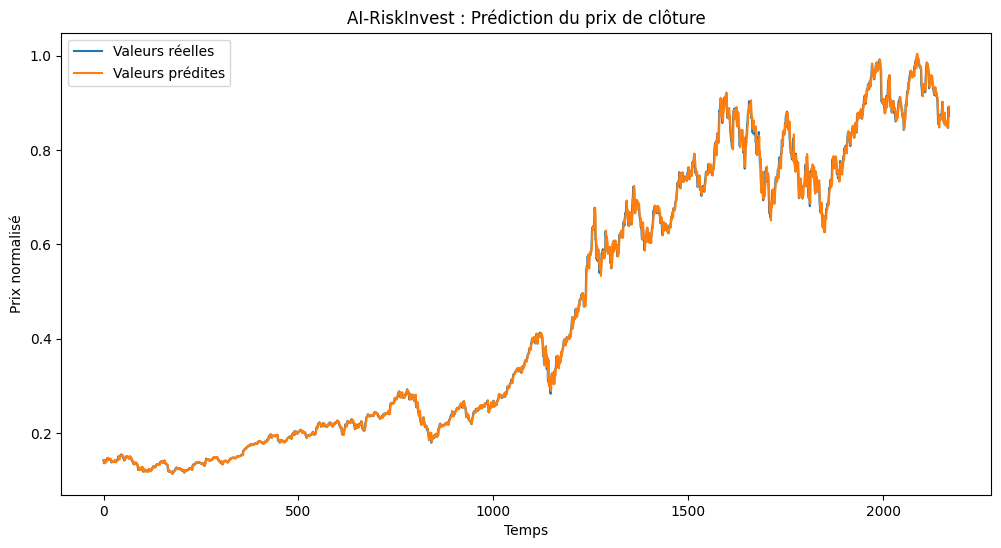

In [76]:

# ===================== 12. VISUALISATION =====================

plt.figure(figsize=(12,6))
plt.plot(y_test, label="Valeurs réelles")
plt.plot(predictions, label="Valeurs prédites")
plt.title("AI-RiskInvest : Prédiction du prix de clôture")
plt.xlabel("Temps")
plt.ylabel("Prix normalisé")
plt.legend()
plt.show()



In [77]:

# ===================== 13. SAUVEGARDE DU MODÈLE =====================

joblib.dump(model, "riskinvest_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Modèle et scaler sauvegardés avec succès.")




Modèle et scaler sauvegardés avec succès.


In [78]:
# ===================== 14. FONCTION POUR L’APPLICATION =====================

def predict_next_price(last_60_prices):
    """
    Fonction utilisée dans l'application pour prédire le prochain prix
    """
    last_60_prices = np.array(last_60_prices).reshape(-1, 1)
    last_60_scaled = scaler.transform(last_60_prices)
    X_input = last_60_scaled.reshape(1, -1)
    prediction = model.predict(X_input)
    return scaler.inverse_transform(prediction.reshape(-1,1))[0][0]


print("""
Le système AI-RiskInvest est maintenant complet.
Il permet la prédiction des prix boursiers,
l’évaluation du risque et son intégration directe
dans une application intelligente.
""")


Le système AI-RiskInvest est maintenant complet.
Il permet la prédiction des prix boursiers,
l’évaluation du risque et son intégration directe
dans une application intelligente.

